In [13]:
import os,sys,inspect
import os
import joblib
import tensorflow.compat.v1 as tf
import numpy as np
import h5py
import scipy.sparse.linalg as la
import scipy.sparse as sp
import scipy
import time
from sklearn.neighbors import kneighbors_graph

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [18]:
path_dataset = '/Users/liujiaoyang/tensorflow/MGCNN/Data/Synthetic_Netflix/synthetic_netflix.mat'
path_implicit = '/Users/liujiaoyang/tensorflow/MGCNN/Data/Synthetic_Netflix/S_implicit.mat'

In [19]:
# auxiliary functions:

# import matlab files in python
def load_matlab_file(path_file, name_field):
    """
    load '.mat' files
    inputs:
        path_file, string containing the file path
        name_field, string containig the field name (default='shape')
    warning:
        '.mat' files should be saved in the '-v7.3' format
    """
    db = h5py.File(path_file, 'r')
    ds = db[name_field]
    try:
        if 'ir' in ds.keys():
            data = np.asarray(ds['data'])
            ir   = np.asarray(ds['ir'])
            jc   = np.asarray(ds['jc'])
            out  = sp.csc_matrix((data, ir, jc)).astype(np.float32)
    except AttributeError:
        # Transpose in case is a dense matrix because of the row- vs column- major ordering between python and matlab
        out = np.asarray(ds).astype(np.float32).T

    db.close()

    return out

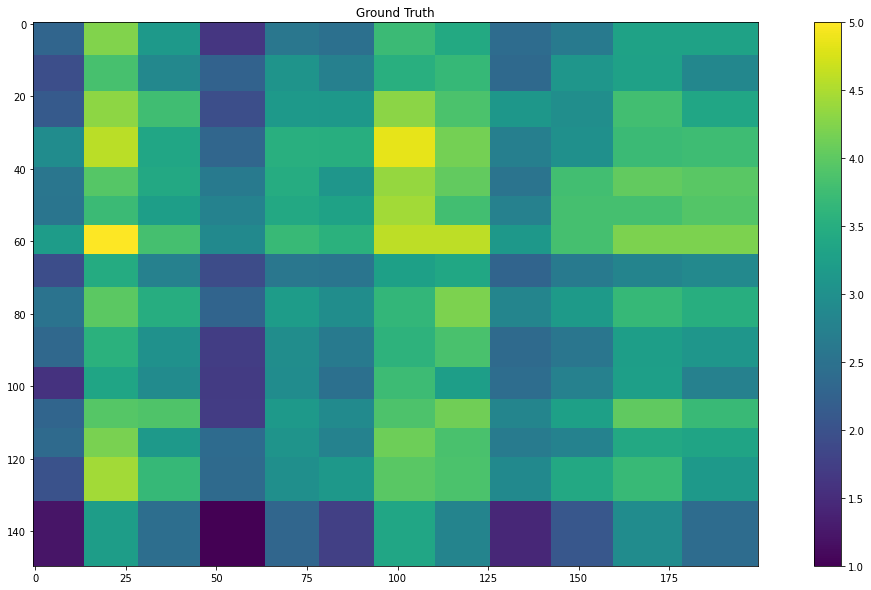

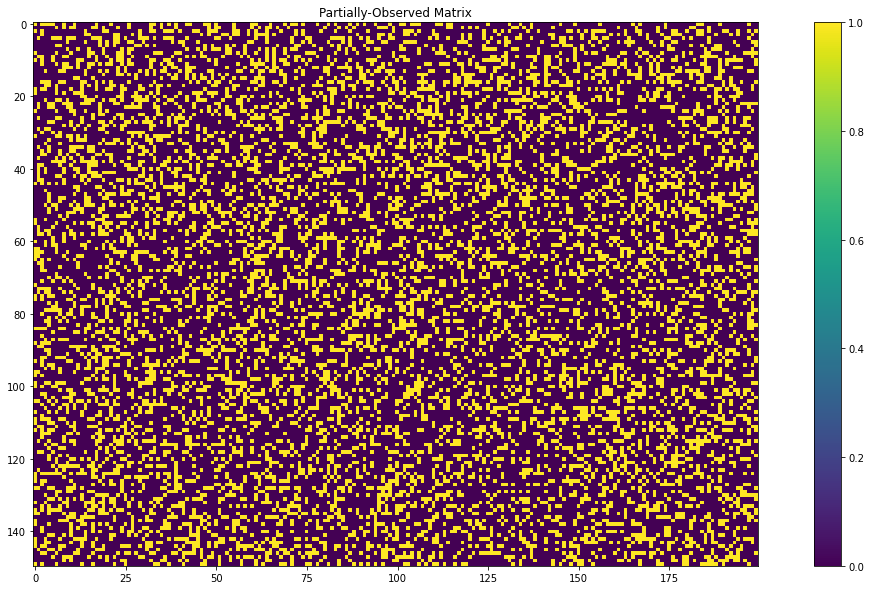

In [23]:
#loading of the required matrices
M = load_matlab_file(path_dataset, 'M')
O = load_matlab_file(path_dataset, 'O')
Otraining = load_matlab_file(path_dataset, 'Otraining')
Otest = load_matlab_file(path_dataset, 'Otest')
Wrow = load_matlab_file(path_dataset, 'Wrow') #sparse
Wcol = load_matlab_file(path_dataset, 'Wcol') #sparse
Su_imp = load_matlab_file(path_implicit, 'Su_imp')
Sb_imp = load_matlab_file(path_implicit, 'Sb_imp')

plt.figure(figsize=(20,10))
plt.imshow(M)
plt.title('Ground Truth')
plt.colorbar()

plt.figure(figsize=(20,10))
plt.imshow(O)
plt.title('Partially-Observed Matrix')
plt.colorbar()

In [24]:
# extract implicit features
user_impGraph = kneighbors_graph(Su_imp, 10)
item_impGraph = kneighbors_graph(Sb_imp, 10)

# save sparse matrix
sp.save_npz('user_impGraph.npz', user_impGraph, False)
sp.save_npz('item_impGraph.npz', item_impGraph, False)

# print
print(user_impGraph.shape)
print(item_impGraph.shape)

(150, 150)
(200, 200)


In [25]:
# combine explicit and implicit graphs
Wrow = 0.7 * Wrow + 0.3 * user_impGraph
Wcol = 0.7 * Wcol + 0.3 * item_impGraph

In [26]:
np.random.seed(0)

pos_tr_samples = np.where(Otraining) #训练集中非零值的位置
# print(pos_tr_samples')
num_tr_samples = len(pos_tr_samples[0]) #训练集中非零值的个数
list_idx = list(range(num_tr_samples)) #创建整数列表0 ~ num_tr_samples-1 #修改1，添加list
np.random.shuffle(list_idx) #打乱序列
idx_data = list_idx[:num_tr_samples//2] #取随机序列前一半为data
idx_train = list_idx[num_tr_samples//2:] #取随机序列后一半作为训练数据

pos_data_samples = (pos_tr_samples[0][idx_data], pos_tr_samples[1][idx_data]) #data的位置
pos_tr_samples = (pos_tr_samples[0][idx_train], pos_tr_samples[1][idx_train]) #训练数据的位置

Odata = np.zeros(M.shape) 
Otraining = np.zeros(M.shape)
#print(Odata)

#把Otraining随机分成两个矩阵，Odata,Otraining分别指示非零值的位置
for k in range(len(pos_data_samples[0])):
    Odata[pos_data_samples[0][k], pos_data_samples[1][k]] = 1 #data位置处为1，其余为零
#print(Odata)  

for k in range(len(pos_tr_samples[0])):
    Otraining[pos_tr_samples[0][k], pos_tr_samples[1][k]] = 1 #训练数据位置处为1，其余为零
#print(Otraining)

print ('Num data samples: %d' % (np.sum(Odata),))
print ('Num train samples: %d' % (np.sum(Otraining),))
print ('Num train+data samples: %d' % (np.sum(Odata+Otraining),))

Num data samples: 2250
Num train samples: 2250
Num train+data samples: 4500


In [27]:
#computation of the normalized laplacians
Lrow = sp.csgraph.laplacian(Wrow, normed=True)
Lcol = sp.csgraph.laplacian(Wcol, normed=True)

In [28]:
class Train_test_matrix_completion:
    
    """
    The neural network model.
    """
    #定义范数：平方和再开方
    def frobenius_norm(self, tensor):
        square_tensor = tf.square(tensor)
        tensor_sum = tf.reduce_sum(square_tensor)
        frobenius_norm = tf.sqrt(tensor_sum)
        return frobenius_norm
    
    #定义二维卷积
    def bid_conv(self, W, b): 
        X = tf.reshape(self.X, [tf.shape(self.M)[0], tf.shape(self.M)[1]])
        
        feat = []
        #collect features
        for k_r in range(self.ord_row): #ord_row 行系数
            for k_c in range(self.ord_col):
                row_lap = self.list_row_cheb_pol[k_r] #行切比雪夫多项式
                col_lap = self.list_col_cheb_pol[k_c] #列切比雪夫多项式
                                                     
                #dense implementation
                c_feat = tf.matmul(row_lap, X, a_is_sparse=False) #矩阵乘，频域滤波
                c_feat = tf.matmul(c_feat, col_lap, b_is_sparse=False)
                feat.append(c_feat)
                
        all_feat = tf.stack(feat, 2)
        all_feat = tf.reshape(all_feat, [-1, self.ord_row*self.ord_col])
        conv_feat = tf.matmul(all_feat, W) + b
        conv_feat = tf.nn.relu(conv_feat) #修正方程
        conv_feat = tf.reshape(conv_feat, [tf.shape(self.M)[0], tf.shape(self.M)[1], self.n_conv_feat])
        return conv_feat #返回多图卷积特征
    
    #计算切比雪夫多项式                
    def compute_cheb_polynomials(self, L, ord_cheb, list_cheb):
        for k in range(ord_cheb):
            if (k==0):
                list_cheb.append(tf.cast(tf.compat.v1.diag(tf.ones([tf.shape(L)[0],])), 'float32'))
            elif (k==1):
                list_cheb.append(tf.cast(L, 'float32'))
            else:
                list_cheb.append(2*tf.matmul(L, list_cheb[k-1])  - list_cheb[k-2])
        
    
    def __init__(self, M, Lr, Lc, Odata, Otraining, Otest, order_chebyshev_col = 5, order_chebyshev_row = 5,
                 num_iterations = 10, gamma=1.0, learning_rate=1e-4, idx_gpu = '/gpu:2'):
        
        #order of the spectral filters
        self.ord_col = order_chebyshev_col 
        self.ord_row = order_chebyshev_row
        self.num_iterations = num_iterations
        self.n_conv_feat = 32 #卷积层输出个数
        
        with tf.Graph().as_default() as g:
                tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
                self.graph = g
                tf.set_random_seed(0)
                with tf.device(idx_gpu):
                    
                        #loading of the laplacians
                        self.Lr = tf.constant(Lr.astype('float32'))
                        self.Lc = tf.constant(Lc.astype('float32'))
                        #归一化的拉普拉斯
                        self.norm_Lr = self.Lr - tf.compat.v1.diag(tf.ones([Lr.shape[0], ]))
                        self.norm_Lc = self.Lc - tf.compat.v1.diag(tf.ones([Lc.shape[0], ]))
                        #compute all chebyshev polynomials a priori
                        self.list_row_cheb_pol = list()
                        self.compute_cheb_polynomials(self.norm_Lr, self.ord_row, self.list_row_cheb_pol)
                        self.list_col_cheb_pol = list()
                        self.compute_cheb_polynomials(self.norm_Lc, self.ord_col, self.list_col_cheb_pol)
                        
                        #definition of constant matrices
                        self.M = tf.constant(M, dtype=tf.float32)
                        self.Odata = tf.constant(Odata, dtype=tf.float32)
                        self.Otraining = tf.constant(Otraining, dtype=tf.float32) #training mask
                        self.Otest = tf.constant(Otest, dtype=tf.float32) #test mask
                         
                        #definition of the NN variables
                        self.W_conv = tf.get_variable("W_conv", shape=[self.ord_col*self.ord_row, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_conv = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        
                        #recurrent N parameters
                        self.W_f = tf.get_variable("W_f", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_i = tf.get_variable("W_i", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_o = tf.get_variable("W_o", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.W_c = tf.get_variable("W_c", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_f = tf.get_variable("U_f", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_i = tf.get_variable("U_i", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_o = tf.get_variable("U_o", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.U_c = tf.get_variable("U_c", shape=[self.n_conv_feat, self.n_conv_feat], initializer=tf.glorot_uniform_initializer())
                        self.b_f = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_i = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_o = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        self.b_c = tf.Variable(tf.zeros([self.n_conv_feat,]))
                        
                        #output parameters
                        self.W_out = tf.get_variable("W_out", shape=[self.n_conv_feat,1], initializer=tf.glorot_uniform_initializer()) 
                        self.b_out = tf.Variable(tf.zeros([1,1]))
                        
                        #########definition of the NN
                        self.X = tf.multiply(self.M, self.Odata) #we may initialize it at random here #初始化待填充矩阵X
                        self.list_X = list()
                        self.list_X.append(tf.identity(self.X))
                        self.X = tf.reshape(self.X, [-1,])
                        
                        #RNN
                        self.h = tf.zeros([M.shape[0]*M.shape[1], self.n_conv_feat])
                        self.c = tf.zeros([M.shape[0]*M.shape[1], self.n_conv_feat])
                        
                        for k in range(self.num_iterations):
                            #bidimensional convolution
                            self.x_conv = self.bid_conv(self.W_conv, self.b_conv) #N, N, n_conv_feat
                            self.x_conv = tf.reshape(self.x_conv, [-1, self.n_conv_feat])
                            
                            self.f = tf.sigmoid(tf.matmul(self.x_conv, self.W_f) + tf.matmul(self.h, self.U_f) + self.b_f)
                            self.i = tf.sigmoid(tf.matmul(self.x_conv, self.W_i) + tf.matmul(self.h, self.U_i) + self.b_i)
                            self.o = tf.sigmoid(tf.matmul(self.x_conv, self.W_o) + tf.matmul(self.h, self.U_o) + self.b_o)
                            
                            self.update_c = tf.sigmoid(tf.matmul(self.x_conv, self.W_c) + tf.matmul(self.h, self.U_c) + self.b_c)
                            self.c = tf.multiply(self.f, self.c) + tf.multiply(self.i, self.update_c)
                            self.h = tf.multiply(self.o, tf.sigmoid(self.c))
                            
                            #compute update of matrix X
                            self.delta_x = tf.tanh(tf.matmul(self.c, self.W_out) + self.b_out)
                            self.X += tf.squeeze(self.delta_x)
                            self.list_X.append(tf.identity(tf.reshape(self.X, [tf.shape(self.M)[0], tf.shape(self.M)[1]])))
                            
                            
                        self.X = tf.reshape(self.X, [tf.shape(self.M)[0], tf.shape(self.M)[1]])
                        #########loss definition
                        
                        #computation of the accuracy term
                        self.norm_X = 1+4*(self.X-tf.reduce_min(self.X))/(tf.reduce_max(self.X-tf.reduce_min(self.X)))
                        frob_tensor = tf.multiply(self.Otraining + self.Odata, self.norm_X - M)
                        self.loss_frob = tf.square(self.frobenius_norm(frob_tensor))/np.sum(Otraining+Odata)
                        
                        #computation of the regularization terms
                        trace_col_tensor = tf.matmul(tf.matmul(self.X, self.Lc), self.X, transpose_b=True)
                        self.loss_trace_col = tf.trace(trace_col_tensor)
                        trace_row_tensor = tf.matmul(tf.matmul(self.X, self.Lr, transpose_a=True), self.X)
                        self.loss_trace_row = tf.trace(trace_row_tensor)
                        
                        #training loss definition
                        self.loss = self.loss_frob + (gamma/2)*(self.loss_trace_col + self.loss_trace_row)
                        
                        #test loss definition
                        self.predictions = tf.multiply(self.Otest, self.norm_X - self.M)
                        self.predictions_error = self.frobenius_norm(self.predictions)

                        #definition of the solver
                        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
                        
                        self.var_grad = tf.gradients(self.loss, tf.trainable_variables())
                        self.norm_grad = self.frobenius_norm(tf.concat([tf.reshape(g, [-1]) for g in self.var_grad], 0))

                        # Create a session for running Ops on the Graph.
                        config = tf.ConfigProto(allow_soft_placement = True)
                        config.gpu_options.allow_growth = True
                        self.session = tf.Session(config=config)

                        # Run the Op to initialize the variables.
                        init = tf.initialize_all_variables()
                        self.session.run(init)

In [31]:
ord_col = 4
ord_row = 4

learning_obj = Train_test_matrix_completion(M, Lrow.toarray(), Lcol.toarray(), Odata, Otraining, Otest, 
                                            order_chebyshev_col = ord_col, order_chebyshev_row = ord_row, 
                                            gamma=1e-8, learning_rate=1e-4)

num_iter_test = 10
num_total_iter_training = 20000 #25000

num_iter = 0

list_training_loss = list()
list_training_norm_grad = list()
list_test_pred_error = list()
list_predictions = list()
list_X = list()

list_training_times = list()
list_test_times = list()
list_grad_X = list()

list_X_evolutions = list()

In [ ]:
num_iter = 0
for k in range(num_iter, num_total_iter_training):

    tic = time.time()
    _, current_training_loss, norm_grad, X_grad = learning_obj.session.run([learning_obj.optimizer, learning_obj.loss, 
                                                                            learning_obj.norm_grad, learning_obj.var_grad]) 
    training_time = time.time() - tic

    list_training_loss.append(current_training_loss)
    list_training_norm_grad.append(norm_grad)
    list_training_times.append(training_time)
        
    if (np.mod(num_iter, num_iter_test)==0):
        msg = "[TRN] iter = %03i, cost = %3.2e, |grad| = %.2e (%3.2es)" \
                                    % (num_iter, list_training_loss[-1], list_training_norm_grad[-1], training_time)
        print (msg)
            
        #Test Code
        tic = time.time()
        pred_error, preds, X = learning_obj.session.run([learning_obj.predictions_error, learning_obj.predictions,
                                                                             learning_obj.norm_X]) 
        c_X_evolutions = learning_obj.session.run(learning_obj.list_X)
        list_X_evolutions.append(c_X_evolutions)

        test_time = time.time() - tic

        list_test_pred_error.append(pred_error)
        list_X.append(X)
        list_test_times.append(test_time)
        msg =  "[TST] iter = %03i, cost = %3.2e (%3.2es)" % (num_iter, list_test_pred_error[-1], test_time)
        print (msg)
            
    num_iter += 1

[TRN] iter = 000, cost = 8.11e-01, |grad| = 7.95e+00 (2.19e+00s)
[TST] iter = 000, cost = 5.55e+01 (7.40e-01s)
[TRN] iter = 010, cost = 7.29e-01, |grad| = 3.45e+00 (5.48e-01s)
[TST] iter = 010, cost = 5.63e+01 (2.59e-01s)
[TRN] iter = 020, cost = 6.89e-01, |grad| = 2.21e+00 (5.62e-01s)
[TST] iter = 020, cost = 5.41e+01 (2.60e-01s)
[TRN] iter = 030, cost = 6.64e-01, |grad| = 1.43e+00 (5.79e-01s)
[TST] iter = 030, cost = 5.39e+01 (2.69e-01s)
[TRN] iter = 040, cost = 6.48e-01, |grad| = 7.65e-01 (5.64e-01s)
[TST] iter = 040, cost = 5.33e+01 (2.63e-01s)
[TRN] iter = 050, cost = 6.35e-01, |grad| = 6.59e-01 (5.71e-01s)
[TST] iter = 050, cost = 5.30e+01 (2.78e-01s)
[TRN] iter = 060, cost = 6.22e-01, |grad| = 7.15e-01 (5.85e-01s)
[TST] iter = 060, cost = 5.28e+01 (2.73e-01s)
[TRN] iter = 070, cost = 6.09e-01, |grad| = 6.34e-01 (5.83e-01s)
[TST] iter = 070, cost = 5.25e+01 (2.71e-01s)
[TRN] iter = 080, cost = 5.96e-01, |grad| = 6.42e-01 (5.79e-01s)
[TST] iter = 080, cost = 5.22e+01 (2.65e-01s)
[

[TRN] iter = 740, cost = 7.45e-02, |grad| = 1.76e+00 (6.33e-01s)
[TST] iter = 740, cost = 2.26e+01 (3.15e-01s)
[TRN] iter = 750, cost = 7.35e-02, |grad| = 1.36e+00 (6.23e-01s)
[TST] iter = 750, cost = 2.25e+01 (2.83e-01s)
[TRN] iter = 760, cost = 7.26e-02, |grad| = 1.01e+00 (6.16e-01s)
[TST] iter = 760, cost = 2.24e+01 (3.01e-01s)
[TRN] iter = 770, cost = 7.18e-02, |grad| = 8.37e-01 (6.33e-01s)
[TST] iter = 770, cost = 2.23e+01 (3.06e-01s)
[TRN] iter = 780, cost = 7.14e-02, |grad| = 2.68e+00 (6.34e-01s)
[TST] iter = 780, cost = 2.23e+01 (2.91e-01s)
[TRN] iter = 790, cost = 7.03e-02, |grad| = 5.57e-01 (6.05e-01s)
[TST] iter = 790, cost = 2.21e+01 (3.00e-01s)
[TRN] iter = 800, cost = 6.96e-02, |grad| = 1.12e+00 (6.15e-01s)
[TST] iter = 800, cost = 2.20e+01 (2.98e-01s)
[TRN] iter = 810, cost = 6.89e-02, |grad| = 7.12e-01 (6.60e-01s)
[TST] iter = 810, cost = 2.20e+01 (2.92e-01s)
[TRN] iter = 820, cost = 6.82e-02, |grad| = 8.77e-01 (6.27e-01s)
[TST] iter = 820, cost = 2.19e+01 (3.09e-01s)
[

[TRN] iter = 1470, cost = 4.12e-02, |grad| = 5.22e-02 (6.10e-01s)
[TST] iter = 1470, cost = 1.74e+01 (2.84e-01s)
[TRN] iter = 1480, cost = 4.09e-02, |grad| = 5.11e-02 (6.19e-01s)
[TST] iter = 1480, cost = 1.73e+01 (2.96e-01s)
[TRN] iter = 1490, cost = 4.06e-02, |grad| = 5.34e-02 (6.04e-01s)
[TST] iter = 1490, cost = 1.72e+01 (3.00e-01s)
[TRN] iter = 1500, cost = 4.03e-02, |grad| = 5.04e-02 (6.27e-01s)
[TST] iter = 1500, cost = 1.72e+01 (2.90e-01s)
[TRN] iter = 1510, cost = 4.00e-02, |grad| = 5.15e-02 (6.07e-01s)
[TST] iter = 1510, cost = 1.71e+01 (2.88e-01s)
[TRN] iter = 1520, cost = 3.97e-02, |grad| = 4.82e-02 (6.09e-01s)
[TST] iter = 1520, cost = 1.70e+01 (2.80e-01s)
[TRN] iter = 1530, cost = 3.94e-02, |grad| = 4.83e-02 (6.11e-01s)
[TST] iter = 1530, cost = 1.70e+01 (3.00e-01s)
[TRN] iter = 1540, cost = 3.91e-02, |grad| = 4.70e-02 (6.03e-01s)
[TST] iter = 1540, cost = 1.69e+01 (3.06e-01s)
[TRN] iter = 1550, cost = 3.89e-02, |grad| = 4.99e-02 (6.22e-01s)
[TST] iter = 1550, cost = 1.69

[TST] iter = 2190, cost = 1.41e+01 (2.86e-01s)
[TRN] iter = 2200, cost = 2.65e-02, |grad| = 2.33e-02 (6.29e-01s)
[TST] iter = 2200, cost = 1.40e+01 (2.91e-01s)
[TRN] iter = 2210, cost = 2.64e-02, |grad| = 2.30e-02 (6.08e-01s)
[TST] iter = 2210, cost = 1.40e+01 (2.91e-01s)
[TRN] iter = 2220, cost = 2.63e-02, |grad| = 2.28e-02 (6.17e-01s)
[TST] iter = 2220, cost = 1.40e+01 (2.88e-01s)
[TRN] iter = 2230, cost = 2.61e-02, |grad| = 2.28e-02 (6.24e-01s)
[TST] iter = 2230, cost = 1.40e+01 (2.89e-01s)
[TRN] iter = 2240, cost = 2.60e-02, |grad| = 2.27e-02 (6.26e-01s)
[TST] iter = 2240, cost = 1.39e+01 (2.93e-01s)
[TRN] iter = 2250, cost = 2.59e-02, |grad| = 2.24e-02 (6.18e-01s)
[TST] iter = 2250, cost = 1.39e+01 (2.95e-01s)
[TRN] iter = 2260, cost = 2.58e-02, |grad| = 2.26e-02 (6.12e-01s)
[TST] iter = 2260, cost = 1.39e+01 (2.93e-01s)
[TRN] iter = 2270, cost = 2.56e-02, |grad| = 2.25e-02 (6.29e-01s)
[TST] iter = 2270, cost = 1.39e+01 (2.92e-01s)
[TRN] iter = 2280, cost = 2.55e-02, |grad| = 2.26

[TST] iter = 2920, cost = 1.22e+01 (3.09e-01s)
[TRN] iter = 2930, cost = 1.91e-02, |grad| = 3.29e-02 (6.61e-01s)
[TST] iter = 2930, cost = 1.22e+01 (3.11e-01s)
[TRN] iter = 2940, cost = 1.90e-02, |grad| = 3.35e-02 (6.61e-01s)
[TST] iter = 2940, cost = 1.22e+01 (3.19e-01s)
[TRN] iter = 2950, cost = 1.90e-02, |grad| = 3.39e-02 (6.86e-01s)
[TST] iter = 2950, cost = 1.22e+01 (3.13e-01s)
[TRN] iter = 2960, cost = 1.89e-02, |grad| = 3.13e-02 (6.54e-01s)
[TST] iter = 2960, cost = 1.22e+01 (3.08e-01s)
[TRN] iter = 2970, cost = 1.88e-02, |grad| = 3.06e-02 (6.85e-01s)
[TST] iter = 2970, cost = 1.21e+01 (3.14e-01s)
[TRN] iter = 2980, cost = 1.87e-02, |grad| = 3.18e-02 (6.97e-01s)
[TST] iter = 2980, cost = 1.21e+01 (3.02e-01s)
[TRN] iter = 2990, cost = 1.87e-02, |grad| = 3.05e-02 (6.71e-01s)
[TST] iter = 2990, cost = 1.21e+01 (3.12e-01s)
[TRN] iter = 3000, cost = 1.86e-02, |grad| = 3.07e-02 (6.67e-01s)
[TST] iter = 3000, cost = 1.21e+01 (3.18e-01s)
[TRN] iter = 3010, cost = 1.85e-02, |grad| = 2.96

[TST] iter = 3650, cost = 1.07e+01 (3.10e-01s)
[TRN] iter = 3660, cost = 1.44e-02, |grad| = 2.49e-02 (6.65e-01s)
[TST] iter = 3660, cost = 1.07e+01 (3.05e-01s)
[TRN] iter = 3670, cost = 1.43e-02, |grad| = 2.65e-02 (6.57e-01s)
[TST] iter = 3670, cost = 1.07e+01 (3.13e-01s)
[TRN] iter = 3680, cost = 1.42e-02, |grad| = 1.61e-02 (6.67e-01s)
[TST] iter = 3680, cost = 1.07e+01 (3.32e-01s)
[TRN] iter = 3690, cost = 1.42e-02, |grad| = 2.35e-02 (6.56e-01s)
[TST] iter = 3690, cost = 1.07e+01 (3.12e-01s)
[TRN] iter = 3700, cost = 1.41e-02, |grad| = 4.41e-02 (6.53e-01s)
[TST] iter = 3700, cost = 1.07e+01 (2.98e-01s)
[TRN] iter = 3710, cost = 1.41e-02, |grad| = 2.16e-02 (6.59e-01s)
[TST] iter = 3710, cost = 1.06e+01 (3.08e-01s)
[TRN] iter = 3720, cost = 1.40e-02, |grad| = 2.06e-02 (6.62e-01s)
[TST] iter = 3720, cost = 1.06e+01 (3.01e-01s)
[TRN] iter = 3730, cost = 1.40e-02, |grad| = 2.37e-02 (6.59e-01s)
[TST] iter = 3730, cost = 1.06e+01 (3.04e-01s)
[TRN] iter = 3740, cost = 1.39e-02, |grad| = 2.92

[TST] iter = 4380, cost = 9.66e+00 (3.18e-01s)
[TRN] iter = 4390, cost = 1.11e-02, |grad| = 1.89e-02 (6.67e-01s)
[TST] iter = 4390, cost = 9.65e+00 (3.18e-01s)
[TRN] iter = 4400, cost = 1.11e-02, |grad| = 1.03e-02 (6.82e-01s)
[TST] iter = 4400, cost = 9.64e+00 (3.29e-01s)
[TRN] iter = 4410, cost = 1.10e-02, |grad| = 1.75e-02 (6.65e-01s)
[TST] iter = 4410, cost = 9.62e+00 (3.04e-01s)
[TRN] iter = 4420, cost = 1.10e-02, |grad| = 1.43e-02 (6.77e-01s)
[TST] iter = 4420, cost = 9.61e+00 (3.18e-01s)
[TRN] iter = 4430, cost = 1.10e-02, |grad| = 2.69e-02 (6.81e-01s)
[TST] iter = 4430, cost = 9.60e+00 (3.19e-01s)
[TRN] iter = 4440, cost = 1.09e-02, |grad| = 1.01e-02 (7.22e-01s)
[TST] iter = 4440, cost = 9.58e+00 (3.32e-01s)
[TRN] iter = 4450, cost = 1.09e-02, |grad| = 2.88e-02 (6.83e-01s)
[TST] iter = 4450, cost = 9.57e+00 (3.29e-01s)
[TRN] iter = 4460, cost = 1.09e-02, |grad| = 1.93e-02 (6.79e-01s)
[TST] iter = 4460, cost = 9.56e+00 (3.04e-01s)
[TRN] iter = 4470, cost = 1.08e-02, |grad| = 1.33

[TST] iter = 5110, cost = 8.84e+00 (3.15e-01s)
[TRN] iter = 5120, cost = 8.93e-03, |grad| = 1.26e-02 (6.92e-01s)
[TST] iter = 5120, cost = 8.83e+00 (3.28e-01s)
[TRN] iter = 5130, cost = 8.91e-03, |grad| = 1.50e-02 (6.83e-01s)
[TST] iter = 5130, cost = 8.82e+00 (3.13e-01s)
[TRN] iter = 5140, cost = 8.88e-03, |grad| = 1.00e-02 (6.78e-01s)
[TST] iter = 5140, cost = 8.82e+00 (3.21e-01s)
[TRN] iter = 5150, cost = 8.85e-03, |grad| = 2.43e-02 (6.83e-01s)
[TST] iter = 5150, cost = 8.81e+00 (3.33e-01s)
[TRN] iter = 5160, cost = 8.83e-03, |grad| = 2.21e-02 (6.99e-01s)
[TST] iter = 5160, cost = 8.80e+00 (3.29e-01s)
[TRN] iter = 5170, cost = 8.81e-03, |grad| = 1.62e-02 (6.73e-01s)
[TST] iter = 5170, cost = 8.78e+00 (3.23e-01s)
[TRN] iter = 5180, cost = 8.78e-03, |grad| = 1.92e-02 (6.71e-01s)
[TST] iter = 5180, cost = 8.78e+00 (3.21e-01s)
[TRN] iter = 5190, cost = 8.76e-03, |grad| = 3.39e-02 (6.79e-01s)
[TST] iter = 5190, cost = 8.76e+00 (3.31e-01s)
[TRN] iter = 5200, cost = 8.73e-03, |grad| = 1.02

[TST] iter = 5840, cost = 8.12e+00 (3.34e-01s)
[TRN] iter = 5850, cost = 7.29e-03, |grad| = 3.97e-02 (6.92e-01s)
[TST] iter = 5850, cost = 8.11e+00 (3.29e-01s)
[TRN] iter = 5860, cost = 7.26e-03, |grad| = 2.79e-02 (7.06e-01s)
[TST] iter = 5860, cost = 8.10e+00 (3.41e-01s)
[TRN] iter = 5870, cost = 7.24e-03, |grad| = 1.98e-02 (7.12e-01s)
[TST] iter = 5870, cost = 8.09e+00 (3.48e-01s)
[TRN] iter = 5880, cost = 7.22e-03, |grad| = 3.10e-02 (6.92e-01s)
[TST] iter = 5880, cost = 8.08e+00 (3.35e-01s)
[TRN] iter = 5890, cost = 7.20e-03, |grad| = 1.12e-02 (6.89e-01s)
[TST] iter = 5890, cost = 8.07e+00 (3.38e-01s)
[TRN] iter = 5900, cost = 7.18e-03, |grad| = 2.33e-02 (6.96e-01s)
[TST] iter = 5900, cost = 8.07e+00 (3.30e-01s)
[TRN] iter = 5910, cost = 7.16e-03, |grad| = 2.02e-02 (6.94e-01s)
[TST] iter = 5910, cost = 8.05e+00 (3.34e-01s)
[TRN] iter = 5920, cost = 7.14e-03, |grad| = 1.45e-02 (6.93e-01s)
[TST] iter = 5920, cost = 8.05e+00 (3.36e-01s)
[TRN] iter = 5930, cost = 7.12e-03, |grad| = 2.77

[TST] iter = 6570, cost = 7.44e+00 (3.34e-01s)
[TRN] iter = 6580, cost = 5.92e-03, |grad| = 2.21e-02 (6.98e-01s)
[TST] iter = 6580, cost = 7.43e+00 (3.36e-01s)
[TRN] iter = 6590, cost = 5.90e-03, |grad| = 2.58e-02 (6.98e-01s)
[TST] iter = 6590, cost = 7.43e+00 (3.43e-01s)
[TRN] iter = 6600, cost = 5.88e-03, |grad| = 2.12e-02 (6.94e-01s)
[TST] iter = 6600, cost = 7.42e+00 (3.46e-01s)
[TRN] iter = 6610, cost = 5.87e-03, |grad| = 2.25e-02 (7.04e-01s)
[TST] iter = 6610, cost = 7.41e+00 (3.42e-01s)
[TRN] iter = 6620, cost = 5.85e-03, |grad| = 1.86e-02 (6.89e-01s)
[TST] iter = 6620, cost = 7.39e+00 (3.39e-01s)
[TRN] iter = 6630, cost = 5.84e-03, |grad| = 4.37e-02 (7.01e-01s)
[TST] iter = 6630, cost = 7.40e+00 (3.38e-01s)
[TRN] iter = 6640, cost = 5.82e-03, |grad| = 2.16e-02 (6.91e-01s)
[TST] iter = 6640, cost = 7.39e+00 (3.36e-01s)
[TRN] iter = 6650, cost = 5.81e-03, |grad| = 1.97e-02 (6.73e-01s)
[TST] iter = 6650, cost = 7.38e+00 (3.37e-01s)
[TRN] iter = 6660, cost = 5.80e-03, |grad| = 4.88

[TST] iter = 7300, cost = 6.92e+00 (3.51e-01s)
[TRN] iter = 7310, cost = 4.95e-03, |grad| = 2.66e-02 (7.11e-01s)
[TST] iter = 7310, cost = 6.91e+00 (3.44e-01s)
[TRN] iter = 7320, cost = 4.94e-03, |grad| = 2.04e-02 (7.15e-01s)
[TST] iter = 7320, cost = 6.91e+00 (3.63e-01s)
[TRN] iter = 7330, cost = 4.93e-03, |grad| = 1.79e-02 (7.41e-01s)
[TST] iter = 7330, cost = 6.90e+00 (3.60e-01s)
[TRN] iter = 7340, cost = 4.92e-03, |grad| = 4.45e-02 (7.22e-01s)
[TST] iter = 7340, cost = 6.89e+00 (3.53e-01s)
[TRN] iter = 7350, cost = 4.92e-03, |grad| = 7.71e-02 (7.21e-01s)
[TST] iter = 7350, cost = 6.89e+00 (3.57e-01s)
[TRN] iter = 7360, cost = 4.90e-03, |grad| = 5.07e-02 (7.17e-01s)
[TST] iter = 7360, cost = 6.88e+00 (3.54e-01s)
[TRN] iter = 7370, cost = 4.89e-03, |grad| = 1.95e-02 (7.09e-01s)
[TST] iter = 7370, cost = 6.88e+00 (3.42e-01s)
[TRN] iter = 7380, cost = 4.89e-03, |grad| = 6.13e-02 (7.34e-01s)
[TST] iter = 7380, cost = 6.87e+00 (3.57e-01s)
[TRN] iter = 7390, cost = 4.87e-03, |grad| = 3.82

[TST] iter = 8030, cost = 6.57e+00 (3.61e-01s)
[TRN] iter = 8040, cost = 4.35e-03, |grad| = 3.56e-02 (7.61e-01s)
[TST] iter = 8040, cost = 6.56e+00 (3.74e-01s)
[TRN] iter = 8050, cost = 4.34e-03, |grad| = 3.26e-02 (7.33e-01s)
[TST] iter = 8050, cost = 6.56e+00 (3.55e-01s)
[TRN] iter = 8060, cost = 4.33e-03, |grad| = 3.69e-02 (7.23e-01s)
[TST] iter = 8060, cost = 6.54e+00 (3.66e-01s)
[TRN] iter = 8070, cost = 4.33e-03, |grad| = 5.39e-02 (7.32e-01s)
[TST] iter = 8070, cost = 6.55e+00 (3.60e-01s)
[TRN] iter = 8080, cost = 4.32e-03, |grad| = 2.90e-02 (7.20e-01s)
[TST] iter = 8080, cost = 6.54e+00 (3.61e-01s)
[TRN] iter = 8090, cost = 4.31e-03, |grad| = 2.21e-02 (7.27e-01s)
[TST] iter = 8090, cost = 6.53e+00 (3.59e-01s)
[TRN] iter = 8100, cost = 4.30e-03, |grad| = 3.18e-02 (7.31e-01s)
[TST] iter = 8100, cost = 6.53e+00 (3.65e-01s)
[TRN] iter = 8110, cost = 4.30e-03, |grad| = 1.85e-02 (7.33e-01s)
[TST] iter = 8110, cost = 6.52e+00 (3.54e-01s)
[TRN] iter = 8120, cost = 4.30e-03, |grad| = 2.42

[TST] iter = 8760, cost = 6.30e+00 (3.81e-01s)
[TRN] iter = 8770, cost = 3.93e-03, |grad| = 3.30e-02 (7.17e-01s)
[TST] iter = 8770, cost = 6.30e+00 (3.62e-01s)
[TRN] iter = 8780, cost = 3.92e-03, |grad| = 3.21e-02 (7.30e-01s)
[TST] iter = 8780, cost = 6.29e+00 (3.59e-01s)
[TRN] iter = 8790, cost = 3.92e-03, |grad| = 5.65e-02 (7.33e-01s)
[TST] iter = 8790, cost = 6.30e+00 (3.57e-01s)
[TRN] iter = 8800, cost = 3.91e-03, |grad| = 3.60e-02 (7.23e-01s)
[TST] iter = 8800, cost = 6.28e+00 (3.70e-01s)
[TRN] iter = 8810, cost = 3.90e-03, |grad| = 3.80e-02 (7.26e-01s)
[TST] iter = 8810, cost = 6.28e+00 (3.64e-01s)
[TRN] iter = 8820, cost = 3.90e-03, |grad| = 4.66e-02 (7.28e-01s)
[TST] iter = 8820, cost = 6.27e+00 (3.64e-01s)
[TRN] iter = 8830, cost = 3.90e-03, |grad| = 6.97e-02 (7.47e-01s)
[TST] iter = 8830, cost = 6.27e+00 (3.65e-01s)
[TRN] iter = 8840, cost = 3.88e-03, |grad| = 1.69e-02 (7.46e-01s)
[TST] iter = 8840, cost = 6.27e+00 (3.67e-01s)
[TRN] iter = 8850, cost = 3.88e-03, |grad| = 3.91

[TST] iter = 9490, cost = 6.10e+00 (3.76e-01s)
[TRN] iter = 9500, cost = 3.59e-03, |grad| = 2.75e-02 (7.54e-01s)
[TST] iter = 9500, cost = 6.09e+00 (3.77e-01s)
[TRN] iter = 9510, cost = 3.59e-03, |grad| = 4.20e-02 (7.31e-01s)
[TST] iter = 9510, cost = 6.09e+00 (3.77e-01s)
[TRN] iter = 9520, cost = 3.58e-03, |grad| = 1.74e-02 (7.47e-01s)
[TST] iter = 9520, cost = 6.08e+00 (3.79e-01s)
[TRN] iter = 9530, cost = 3.58e-03, |grad| = 2.24e-02 (7.54e-01s)
[TST] iter = 9530, cost = 6.09e+00 (3.69e-01s)
[TRN] iter = 9540, cost = 3.58e-03, |grad| = 2.90e-02 (7.48e-01s)
[TST] iter = 9540, cost = 6.08e+00 (3.72e-01s)
[TRN] iter = 9550, cost = 3.58e-03, |grad| = 7.97e-02 (7.44e-01s)
[TST] iter = 9550, cost = 6.08e+00 (3.73e-01s)
[TRN] iter = 9560, cost = 3.59e-03, |grad| = 5.58e-02 (7.68e-01s)
[TST] iter = 9560, cost = 6.08e+00 (3.75e-01s)
[TRN] iter = 9570, cost = 3.57e-03, |grad| = 2.89e-02 (7.38e-01s)
[TST] iter = 9570, cost = 6.08e+00 (3.75e-01s)
[TRN] iter = 9580, cost = 3.57e-03, |grad| = 4.66

[TRN] iter = 10220, cost = 3.35e-03, |grad| = 5.76e-02 (7.89e-01s)
[TST] iter = 10220, cost = 5.93e+00 (3.84e-01s)
[TRN] iter = 10230, cost = 3.35e-03, |grad| = 8.72e-02 (7.76e-01s)
[TST] iter = 10230, cost = 5.94e+00 (3.96e-01s)
[TRN] iter = 10240, cost = 3.34e-03, |grad| = 2.39e-02 (7.79e-01s)
[TST] iter = 10240, cost = 5.93e+00 (3.77e-01s)
[TRN] iter = 10250, cost = 3.33e-03, |grad| = 1.61e-02 (7.73e-01s)
[TST] iter = 10250, cost = 5.92e+00 (3.86e-01s)
[TRN] iter = 10260, cost = 3.35e-03, |grad| = 7.11e-02 (7.75e-01s)
[TST] iter = 10260, cost = 5.93e+00 (3.90e-01s)
[TRN] iter = 10270, cost = 3.33e-03, |grad| = 2.94e-02 (7.81e-01s)
[TST] iter = 10270, cost = 5.92e+00 (3.84e-01s)
[TRN] iter = 10280, cost = 3.33e-03, |grad| = 4.99e-02 (7.81e-01s)
[TST] iter = 10280, cost = 5.92e+00 (3.75e-01s)
[TRN] iter = 10290, cost = 3.32e-03, |grad| = 4.77e-02 (7.82e-01s)
[TST] iter = 10290, cost = 5.92e+00 (3.86e-01s)
[TRN] iter = 10300, cost = 3.32e-03, |grad| = 5.67e-02 (7.91e-01s)
[TST] iter = 

[TST] iter = 10930, cost = 5.79e+00 (4.12e-01s)
[TRN] iter = 10940, cost = 3.14e-03, |grad| = 5.43e-02 (8.03e-01s)
[TST] iter = 10940, cost = 5.80e+00 (4.12e-01s)
[TRN] iter = 10950, cost = 3.14e-03, |grad| = 2.27e-02 (8.03e-01s)
[TST] iter = 10950, cost = 5.79e+00 (4.07e-01s)
[TRN] iter = 10960, cost = 3.12e-03, |grad| = 1.96e-02 (7.90e-01s)
[TST] iter = 10960, cost = 5.79e+00 (4.06e-01s)
[TRN] iter = 10970, cost = 3.13e-03, |grad| = 8.05e-02 (7.79e-01s)
[TST] iter = 10970, cost = 5.80e+00 (3.99e-01s)
[TRN] iter = 10980, cost = 3.12e-03, |grad| = 1.93e-02 (7.89e-01s)
[TST] iter = 10980, cost = 5.78e+00 (4.12e-01s)
[TRN] iter = 10990, cost = 3.13e-03, |grad| = 4.11e-02 (8.15e-01s)
[TST] iter = 10990, cost = 5.79e+00 (4.02e-01s)
[TRN] iter = 11000, cost = 3.12e-03, |grad| = 4.77e-02 (7.91e-01s)
[TST] iter = 11000, cost = 5.78e+00 (4.11e-01s)
[TRN] iter = 11010, cost = 3.12e-03, |grad| = 4.95e-02 (8.11e-01s)
[TST] iter = 11010, cost = 5.79e+00 (4.14e-01s)
[TRN] iter = 11020, cost = 3.11e

[TRN] iter = 11650, cost = 2.94e-03, |grad| = 1.86e-02 (8.56e-01s)
[TST] iter = 11650, cost = 5.67e+00 (4.42e-01s)
[TRN] iter = 11660, cost = 2.94e-03, |grad| = 4.23e-02 (8.03e-01s)
[TST] iter = 11660, cost = 5.67e+00 (4.23e-01s)
[TRN] iter = 11670, cost = 2.94e-03, |grad| = 2.83e-02 (8.05e-01s)
[TST] iter = 11670, cost = 5.66e+00 (4.14e-01s)
[TRN] iter = 11680, cost = 2.94e-03, |grad| = 5.74e-02 (8.12e-01s)
[TST] iter = 11680, cost = 5.67e+00 (4.11e-01s)
[TRN] iter = 11690, cost = 2.94e-03, |grad| = 3.71e-02 (8.02e-01s)
[TST] iter = 11690, cost = 5.67e+00 (4.12e-01s)
[TRN] iter = 11700, cost = 2.93e-03, |grad| = 4.45e-02 (8.02e-01s)
[TST] iter = 11700, cost = 5.67e+00 (4.02e-01s)
[TRN] iter = 11710, cost = 2.93e-03, |grad| = 2.53e-02 (7.97e-01s)
[TST] iter = 11710, cost = 5.67e+00 (3.95e-01s)
[TRN] iter = 11720, cost = 2.92e-03, |grad| = 2.12e-02 (8.06e-01s)
[TST] iter = 11720, cost = 5.66e+00 (4.13e-01s)
[TRN] iter = 11730, cost = 2.92e-03, |grad| = 1.69e-02 (7.89e-01s)
[TST] iter = 

[TST] iter = 12360, cost = 5.56e+00 (4.19e-01s)
[TRN] iter = 12370, cost = 2.78e-03, |grad| = 1.42e-02 (8.06e-01s)
[TST] iter = 12370, cost = 5.57e+00 (4.15e-01s)
[TRN] iter = 12380, cost = 2.78e-03, |grad| = 7.47e-02 (8.02e-01s)
[TST] iter = 12380, cost = 5.57e+00 (4.30e-01s)
[TRN] iter = 12390, cost = 2.78e-03, |grad| = 1.86e-02 (8.30e-01s)
[TST] iter = 12390, cost = 5.57e+00 (4.21e-01s)
[TRN] iter = 12400, cost = 2.78e-03, |grad| = 3.33e-02 (8.23e-01s)
[TST] iter = 12400, cost = 5.57e+00 (4.16e-01s)
[TRN] iter = 12410, cost = 2.77e-03, |grad| = 2.21e-02 (8.18e-01s)
[TST] iter = 12410, cost = 5.56e+00 (4.25e-01s)
[TRN] iter = 12420, cost = 2.78e-03, |grad| = 7.22e-02 (8.27e-01s)
[TST] iter = 12420, cost = 5.57e+00 (4.18e-01s)
[TRN] iter = 12430, cost = 2.77e-03, |grad| = 4.92e-02 (8.13e-01s)
[TST] iter = 12430, cost = 5.56e+00 (4.19e-01s)
[TRN] iter = 12440, cost = 2.77e-03, |grad| = 6.89e-02 (8.07e-01s)
[TST] iter = 12440, cost = 5.57e+00 (4.16e-01s)
[TRN] iter = 12450, cost = 2.77e

[TRN] iter = 13080, cost = 2.66e-03, |grad| = 5.10e-02 (8.13e-01s)
[TST] iter = 13080, cost = 5.49e+00 (4.17e-01s)
[TRN] iter = 13090, cost = 2.65e-03, |grad| = 2.33e-02 (8.21e-01s)
[TST] iter = 13090, cost = 5.48e+00 (4.31e-01s)
[TRN] iter = 13100, cost = 2.64e-03, |grad| = 2.52e-02 (8.32e-01s)
[TST] iter = 13100, cost = 5.48e+00 (4.28e-01s)
[TRN] iter = 13110, cost = 2.64e-03, |grad| = 4.83e-02 (8.29e-01s)
[TST] iter = 13110, cost = 5.48e+00 (4.27e-01s)
[TRN] iter = 13120, cost = 2.65e-03, |grad| = 4.78e-02 (8.30e-01s)
[TST] iter = 13120, cost = 5.48e+00 (4.35e-01s)
[TRN] iter = 13130, cost = 2.64e-03, |grad| = 2.80e-02 (8.28e-01s)
[TST] iter = 13130, cost = 5.48e+00 (4.34e-01s)
[TRN] iter = 13140, cost = 2.64e-03, |grad| = 1.59e-02 (8.28e-01s)
[TST] iter = 13140, cost = 5.48e+00 (4.28e-01s)
[TRN] iter = 13150, cost = 2.64e-03, |grad| = 6.59e-02 (8.41e-01s)
[TST] iter = 13150, cost = 5.48e+00 (4.28e-01s)
[TRN] iter = 13160, cost = 2.63e-03, |grad| = 2.35e-02 (8.33e-01s)
[TST] iter = 

[TST] iter = 13790, cost = 5.42e+00 (4.28e-01s)
[TRN] iter = 13800, cost = 2.53e-03, |grad| = 4.94e-02 (8.29e-01s)
[TST] iter = 13800, cost = 5.42e+00 (4.34e-01s)
[TRN] iter = 13810, cost = 2.53e-03, |grad| = 1.97e-02 (7.98e-01s)
[TST] iter = 13810, cost = 5.41e+00 (4.16e-01s)
[TRN] iter = 13820, cost = 2.53e-03, |grad| = 1.64e-02 (7.96e-01s)
[TST] iter = 13820, cost = 5.42e+00 (4.13e-01s)
[TRN] iter = 13830, cost = 2.53e-03, |grad| = 1.97e-02 (8.03e-01s)
[TST] iter = 13830, cost = 5.42e+00 (4.16e-01s)
[TRN] iter = 13840, cost = 2.53e-03, |grad| = 4.39e-02 (7.69e-01s)
[TST] iter = 13840, cost = 5.42e+00 (4.24e-01s)
[TRN] iter = 13850, cost = 2.53e-03, |grad| = 6.00e-02 (7.95e-01s)
[TST] iter = 13850, cost = 5.41e+00 (4.12e-01s)
[TRN] iter = 13860, cost = 2.52e-03, |grad| = 2.72e-02 (7.90e-01s)
[TST] iter = 13860, cost = 5.41e+00 (4.05e-01s)
[TRN] iter = 13870, cost = 2.53e-03, |grad| = 4.27e-02 (7.88e-01s)
[TST] iter = 13870, cost = 5.41e+00 (4.08e-01s)
[TRN] iter = 13880, cost = 2.52e

[TRN] iter = 14510, cost = 2.43e-03, |grad| = 5.96e-02 (8.29e-01s)
[TST] iter = 14510, cost = 5.36e+00 (4.30e-01s)
[TRN] iter = 14520, cost = 2.44e-03, |grad| = 5.00e-02 (8.41e-01s)
[TST] iter = 14520, cost = 5.36e+00 (4.17e-01s)
[TRN] iter = 14530, cost = 2.43e-03, |grad| = 2.95e-02 (8.34e-01s)
[TST] iter = 14530, cost = 5.35e+00 (4.32e-01s)
[TRN] iter = 14540, cost = 2.43e-03, |grad| = 3.99e-02 (8.49e-01s)
[TST] iter = 14540, cost = 5.35e+00 (4.32e-01s)
[TRN] iter = 14550, cost = 2.42e-03, |grad| = 3.29e-02 (8.46e-01s)
[TST] iter = 14550, cost = 5.35e+00 (4.32e-01s)
[TRN] iter = 14560, cost = 2.43e-03, |grad| = 7.28e-02 (8.42e-01s)
[TST] iter = 14560, cost = 5.34e+00 (4.26e-01s)
[TRN] iter = 14570, cost = 2.42e-03, |grad| = 4.55e-02 (8.26e-01s)
[TST] iter = 14570, cost = 5.35e+00 (4.28e-01s)
[TRN] iter = 14580, cost = 2.43e-03, |grad| = 3.95e-02 (8.50e-01s)
[TST] iter = 14580, cost = 5.35e+00 (4.29e-01s)
[TRN] iter = 14590, cost = 2.42e-03, |grad| = 2.54e-02 (8.53e-01s)
[TST] iter = 

[TST] iter = 15220, cost = 5.30e+00 (4.56e-01s)
[TRN] iter = 15230, cost = 2.34e-03, |grad| = 3.74e-02 (8.72e-01s)
[TST] iter = 15230, cost = 5.30e+00 (4.48e-01s)
[TRN] iter = 15240, cost = 2.35e-03, |grad| = 4.78e-02 (8.53e-01s)
[TST] iter = 15240, cost = 5.29e+00 (4.67e-01s)
[TRN] iter = 15250, cost = 2.35e-03, |grad| = 8.22e-02 (8.64e-01s)
[TST] iter = 15250, cost = 5.30e+00 (4.48e-01s)
[TRN] iter = 15260, cost = 2.33e-03, |grad| = 2.33e-02 (8.60e-01s)
[TST] iter = 15260, cost = 5.29e+00 (4.49e-01s)
[TRN] iter = 15270, cost = 2.35e-03, |grad| = 5.16e-02 (8.64e-01s)
[TST] iter = 15270, cost = 5.29e+00 (4.63e-01s)
[TRN] iter = 15280, cost = 2.33e-03, |grad| = 3.71e-02 (8.78e-01s)
[TST] iter = 15280, cost = 5.29e+00 (4.59e-01s)
[TRN] iter = 15290, cost = 2.34e-03, |grad| = 4.99e-02 (8.67e-01s)
[TST] iter = 15290, cost = 5.30e+00 (4.57e-01s)
[TRN] iter = 15300, cost = 2.34e-03, |grad| = 5.45e-02 (8.46e-01s)
[TST] iter = 15300, cost = 5.30e+00 (4.55e-01s)
[TRN] iter = 15310, cost = 2.34e

Best predictions at iter: 24990 (error: 0.549636)
RMSE: 0.008193


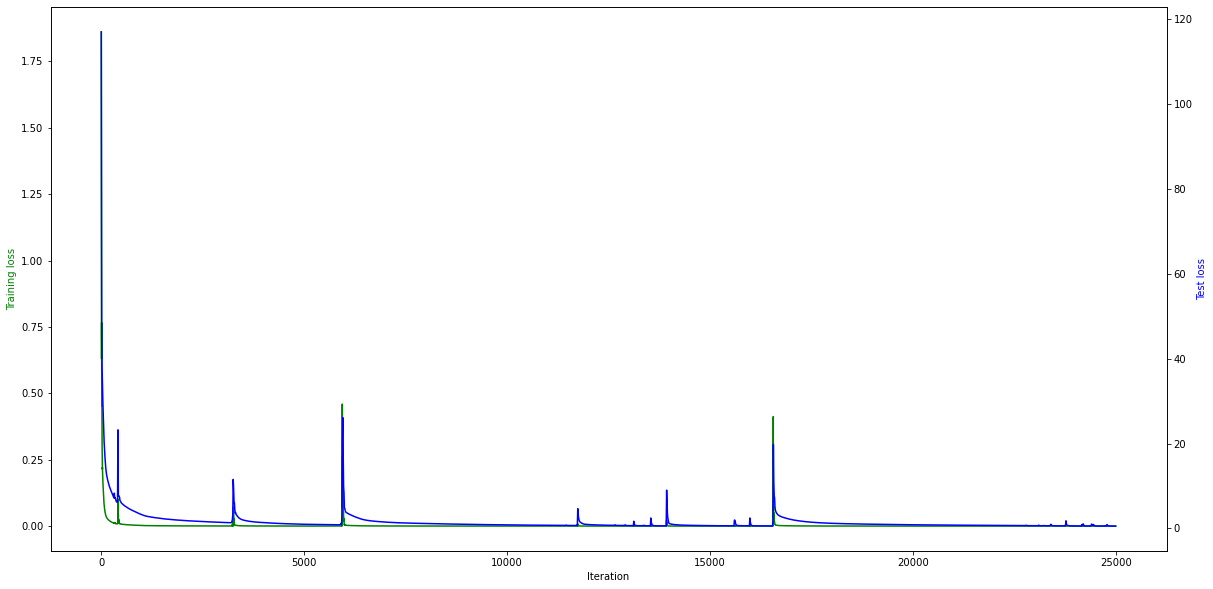

In [37]:
fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot(np.arange(len(list_training_loss)), list_training_loss, 'g-')
ax2.plot(np.arange(len(list_test_pred_error))*num_iter_test, list_test_pred_error, 'b-')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Training loss', color='g')
ax2.set_ylabel('Test loss', color='b')

best_iter = (np.where(np.asarray(list_training_loss)==np.min(list_training_loss))[0][0]//num_iter_test)*num_iter_test
best_pred_error = list_test_pred_error[best_iter//num_iter_test]
print ('Best predictions at iter: %d (error: %f)' % (best_iter, best_pred_error))
RMSE = np.sqrt(np.square(best_pred_error)/np.sum(Otest))
print ('RMSE: %f' % RMSE)

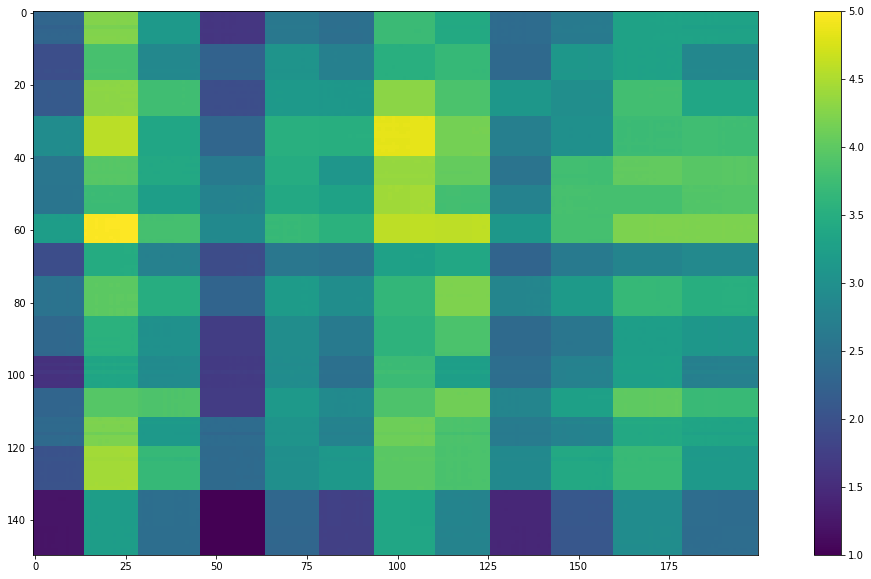

In [38]:
#best X generated
plt.figure(figsize=(20,10))
plt.imshow(list_X[best_iter//num_iter_test])
plt.colorbar()